# Appendix 1: Visualization

本節では、Jupyter Notebook上での原子系の可視化方法に関するテクニックを紹介します。

## 目次

**ASE**

 - atomsのpng画像保存
 - trajのgif画像保存

**nglviewer**

 - ASE + nglviewer での表示。 


**pfcc-extrasの使い方**

- view_ngl関数のそれぞれの引数の説明
   - Tooltipで原子番号やposition表示
   - png, html での保存に対応
   - show charge (要Calculator)
   - show force (要Calculator)

**nglviewer tips**

 - 右クリックで距離・角度・2面角表示

**povray**

 - povrayを用いたgif画像描画

**他の可視化ツール**

 - VMD, OVITOなどでの表示


## 事前準備

ここでは、１つの系 `atoms` を可視化する場合と、時系列である `traj` を表示する場合を紹介します。

まずは、今回可視化する`atoms` と `traj` を用意します。

In [1]:
from ase.build import bulk

atoms = bulk("Si", cubic=True) * (3, 3, 3)

from ase.visualize import view
view(atoms, viewer="ngl")

In [2]:
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v3.0.0")
calculator = ASECalculator(estimator)

In [3]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.io import Trajectory
from ase import units

atoms.calc = calculator
# Set the momenta corresponding to T=500K.
MaxwellBoltzmannDistribution(atoms, temperature_K=5000.0)
# Sets the center-of-mass momentum to zero.
Stationary(atoms)
# Run MD using the VelocityVerlet algorithm
dyn = VelocityVerlet(atoms, 1.0 * units.fs, trajectory="output/dyn.traj")

def print_dyn():
    print(f"Dyn  step: {dyn.get_number_of_steps(): >3}, energy: {atoms.get_total_energy():.3f}")

dyn.attach(print_dyn, interval=10)
dyn.run(100)

Dyn  step:   0, energy: -853.473
Dyn  step:  10, energy: -853.377
Dyn  step:  20, energy: -853.367
Dyn  step:  30, energy: -853.400
Dyn  step:  40, energy: -853.392
Dyn  step:  50, energy: -853.379
Dyn  step:  60, energy: -853.380
Dyn  step:  70, energy: -853.384
Dyn  step:  80, energy: -853.388
Dyn  step:  90, energy: -853.379
Dyn  step: 100, energy: -853.384


True

## ASE

まずはじめに、ASE組み込みの機能を用いたpng画像やgif アニメーションの作成方法を紹介します。

`write` methodを用いて `atoms` の場合は ".png" 、 `traj` の場合は ".gif" の拡張子を指定することでそれぞれの形式での可視化・ファイル保存が可能です。<br/>
保存されたファイルは、たとえば `IPython.display.Image` などを用いるとJupyter Notebook上で可視化可能です。

In [4]:
from ase.io import write
from IPython.display import Image

write("output/Si.png", atoms, rotation="0x,0y,0z")
Image(url="output/Si.png", width=300)

`rotation` の値を変えることで表示する系を回転させることができます。

In [5]:
write("output/Si_rotate_view.png", atoms, rotation="30x,30y,30z")
Image(url="output/Si_rotate_view.png", width=300)

複数の `atoms` = Trajectory `traj` をアニメーションにしたい場合は、 ".gif" 拡張子を指定することで gif動画にできます。

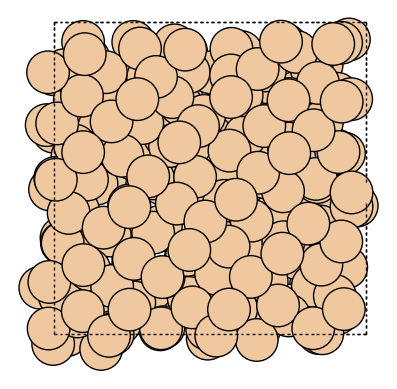

In [6]:
traj = Trajectory("output/dyn.traj")
write("output/Si.gif", traj[::10], rotation="0x,0y,0z")

In [7]:
Image(url="output/Si.gif", width=300)

matplotlibを経由した描画や、ファイル保存も以下のようにできます。

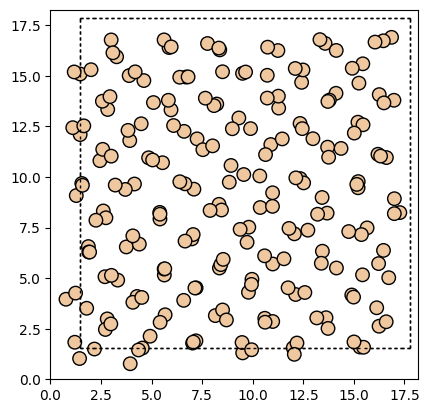

In [8]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.3, rotation=("0x,0y,0z"))
fig.savefig("ase_slab.png")

その他、ASEの可視化関数に関する詳細は以下を参照ください。

 - https://wiki.fysik.dtu.dk/ase//ase/visualize/visualize.html

## nglviewer

`nglview` というライブラリをインストールすることで、3次元の系をInteractiveに動かせるように表示することも可能です。

 - https://github.com/nglviewer/nglview

いくつか方法があります。

### 方法１. nglview提供の機能を使う方法

`atoms` の表示は `show_ase`、`traj` の表示は `show_asetraj` methodを用いることで表示が可能です。

`gui=True` のOptionを加えると、下部にいろいろな設定を変えられるタブが表示されます。

In [9]:
import nglview as nv

nv.show_ase(atoms, gui=True)

NGLWidget()

In [10]:
nv.show_asetraj(traj[::10], gui=True)

NGLWidget(max_frame=10)

`gui_style` で表示形式を変更することもできます。

In [11]:
# v = nv.show_asetraj(traj[::10], gui=False)
# v.gui_style = "ngl"
# v

上記を実行すると、以下のような画面が出ます。

<img src="../assets/nglviewer_style_ngl.jpg"/>

ただし、この表示を行うとHTML でのdocument表示時にcssスタイルが崩れる問題が知られているため、
ここではスクリーンショット表示としています。

 - https://projects.volkamerlab.org/teachopencadd/talktorials/T017_advanced_nglview_usage.html
 - https://github.com/nglviewer/nglview/issues/988

In [12]:
v = nv.show_asetraj(traj[::10], gui=False)
v.add_representation("ball+stick")
v

NGLWidget(max_frame=10)

### 方法２. ASEのViewerを経由して、nglviewを用いる方法

ASE の `view` method に `viewer="ngl"` を指定することでも、表示が可能です。<br/>
ASE のViewerでは右側にいくつかの設定値を変えられるOptionが出てきます。

In [13]:
from ase.visualize import view

view(atoms, viewer="ngl")

Trajectory 表示の場合も同じ `view` methodが使えます。

In [14]:
view(traj[::10], viewer="ngl")

## pfcc-extras

Matlantis内で提供されている`pfcc-extras`ライブラリにて、さらにカスタマイズを加えたviewer を提供しています。

`view_ngl` method を用いて可視化が可能で、以下のような設定ができます。
 - `representations`: NGL Viewer固有の[Representations](https://nglviewer.org/ngl/api/manual/molecular-representations.html)が指定できます。特に使う機能としては、 `"ball+stick"` を指定することで、分子の結合を表示する事ができます。
 - `w, h`: NGL Viewerのwidth, height の指定ができます。

追加機能（一部）:

- Tooltipで原子番号やposition表示
- png, html での保存に対応
- show charge (要Calculator)
- show force (要Calculator)

In [15]:
from pfcc_extras.visualize.view import view_ngl

view_ngl(atoms, representations=["ball+stick"], w=400, h=300)

### Tooltipで原子番号やposition表示

各原子にマウスオーバーをした際に、原子番号や各原子の座標値が表示されるようにしています。

<img src="../assets/pfcc-extras-screenshot-tooltip.jpg" style="width:653px"/>

### png, html 形式での保存に対応

"Download image" ボタンを押すと、今表示されている画像を手元のPCにダウンロードします。<br/>
"Save image" ボタンを押すと、今表示されている画像をカレントディレクトリに保存します。

デフォルトでは、"screenshot.png"となっていますが、拡張子を `.html` にすることで、HTML形式での保存も可能です。

### Show force (要Calculator)

"Show force" にチェックを入れることで、各原子に働いている力 (force vector)の可視化ができます。<br/>
"Force scale" を変えることでベクトルの大きさを変えることができます。

※ `atoms`に対して `calculator` をセットしておく必要があります。

In [16]:
from ase.build import molecule

ch3cho_atoms = molecule("CH3CHO")
ch3cho_atoms.pop(0)
ch3cho_atoms.calc = calculator
view_ngl(ch3cho_atoms, representations=["ball+stick"], w=400, h=300, show_force=True)

### Show charge (要Calculator)

"Show charge" にチェックを入れることで、各原子のchargeの可視化ができます。<br/>
"Charge scale" を変えることで色の濃淡を変えることができます。

※ `atoms`に対して charge計算が可能な`calculator` をセットしておく必要があります。

In [17]:
from ase.build import molecule

ch3cho_atoms = molecule("CH3CHO")
ch3cho_atoms.calc = calculator
view_ngl(ch3cho_atoms, representations=["ball+stick"], w=400, h=300)

`view.add_label` を用いることで、chargeの値を原子上に表示することも可能です。

In [18]:
v = view_ngl(ch3cho_atoms, representations=["ball+stick"], w=400, h=300)
v.gui.show_charge_checkbox.value = True
v.view.add_label(
    color="black", labelType="text",
    labelText=[f"{charge:.2f}" for charge in ch3cho_atoms.get_charges().ravel()],
    zOffset=1.0, attachment="middle_center", radius=0.5)
v

表示例：

<img src="../assets/pfcc-extras-screenshot-charge.png" width="400"></img>

### replace_structure

デフォルトの`nglviewer` では、Trajectoryを表示する際、一番はじめのAtoms に対してBond, Cell のみを設定して、Frameの移動時には座標値のみが更新されます。そのため、

 - Bondの変化 (切れたりつながったり)
 - Cell sizeの変化
 - 原子数の増減　(Ex. LAMMPSでのEvapolateやDepositに相当する操作)
 - 元素種の変化

などがあるようなTrajectoryは正しく表示できません。

以下の例のように、`replace_structure=True` を設定することでこれらのケースも表示することができます。
(ただし、毎回Bond 表示更新などの計算が走るため、少し動作は重くなります。)


In [19]:
ch3cl_atoms = molecule("CH3Cl")

atoms_list = [ch3cl_atoms, ch3cho_atoms]
view_ngl(atoms_list, representations=["ball+stick"], replace_structure=True, w=400, h=300)

## nglviewer tips

### 右クリックでの距離・角度・2面角表示

NGLViewerでは、右クリックを押して原子を選択して、以下のような値を計測・表示させることが可能です。

 - 距離： 原子1を1回右クリック -> 原子2を2回右クリック
 - 角度： 原子1を1回右クリック -> 原子2を1回右クリック -> 原子3を2回右クリック
 - 二面角： 原子1を1回右クリック -> 原子2を1回右クリック -> 原子3を1回右クリック -> 原子4を2回右クリック

In [20]:
view_ngl(ch3cho_atoms, representations=["ball+stick"], replace_structure=True, w=400, h=300)

例：

<div style="clear:both;display:table">
<figure style="width:30%;float:left;margin:0">
  <img src="../assets/nglviewer-2click-distance.gif" alt="distance">
  <figcaption>Show distance between atom 0 and 1</figcaption>
</figure>
<figure style="width:30%;float:left;margin:0">
  <img src="../assets/nglviewer-3click-angle.gif" alt="angle">
  <figcaption>Show angle of atom 0, 1 and 2</figcaption>
</figure>
<figure style="width:30%;float:left;margin:0">
  <img src="../assets/nglviewer-4click-dihedral-angle.gif" alt="dihedral angle">
  <figcaption>Show dihedral angle of atom 0, 1, 2 and 3</figcaption>
</figure>
</div>




## povray

[povray](http://www.povray.org/) を利用して原子系を可視化することも可能です。

povrayをインストールし、`povray`コマンドが使える環境で、以下の関数を実行することで、Trajectoryのgif画像作成ができます。

In [21]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    traj[::10],
    gif_filepath="output/Si_anim.gif",
    povdir="output/pov",
    pngdir="output/png",
    clean=False
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    8.5s finished


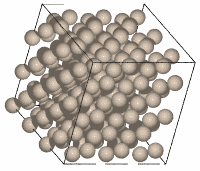

In [22]:
Image("output/Si_anim.gif")

In [23]:
from pfcc_extras.visualize.povray import traj_to_apng

traj_to_apng(
    traj[::10],
    apng_filepath="output/Si_anim.png",
    povdir="output/pov",
    pngdir="output/png",
    clean=False
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    8.1s finished


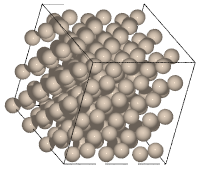

In [24]:
Image("output/Si_anim.png")

## 別の可視化ツールを使う

他の可視化ツールを使いたい場合、traj ファイルを別形式で保存します。<br/>
ここでは、xyz, pdbファイルへの変換を行なっています。これらのファイル形式は以下のツールで利用可能です。

単一の系の表示には、

 - [VESTA](https://jp-minerals.org/vesta/en/)
 - [Avogadro](https://avogadro.cc/)

また、Trajectoryの可視化には、

 - [VMD](https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD)
 - [OVITO](https://www.ovito.org/)

などを使用することができます。

In [25]:
from ase.io import write

# traj = Trajectory("output/dyn.traj")
write("output/si_traj.xyz", traj)
write("output/si_traj.pdb", traj)